/root/sdrfly


SKIQ[574779]: <INFO> libsidekiq v4.18.1 (g58be05ffb)
python3[574779]: [card-0] <INFO> Sidekiq card is serial number=7G2Y, hardware M2 C (rev C), product SKIQ-M2-002 (M.2) (part ES01420*-C0-00)
python3[574779]: [card-0] <INFO> Firmware v2.9
python3[574779]: [card-0] <INFO> Sidekiq: FPGA v3.18.1, (date 24052819, FIFO size 16k)
python3[574779]: [card-0] <INFO> Sidekiq card is configured for an internal reference clock
python3[574779]: [card-0] <INFO> Loading calibration data for Sidekiq M.2
python3[574779]: [card-0] <INFO> RF IC version 5.5.1
python3[574779]: [card-0] <INFO> Number of tx channels supported 1, number of rx channels supported 1
python3[574779]: [card-0] <INFO> Default warp voltage not currently stored (user)
[INFO] Using format CF32.
[INFO] Starting RX Sidekiq Thread
OOOO

Receiving data from SDR...
Data reception complete. Plotting...


OOOOOOOOOOOOOOOOOOOOOOOOOOOO

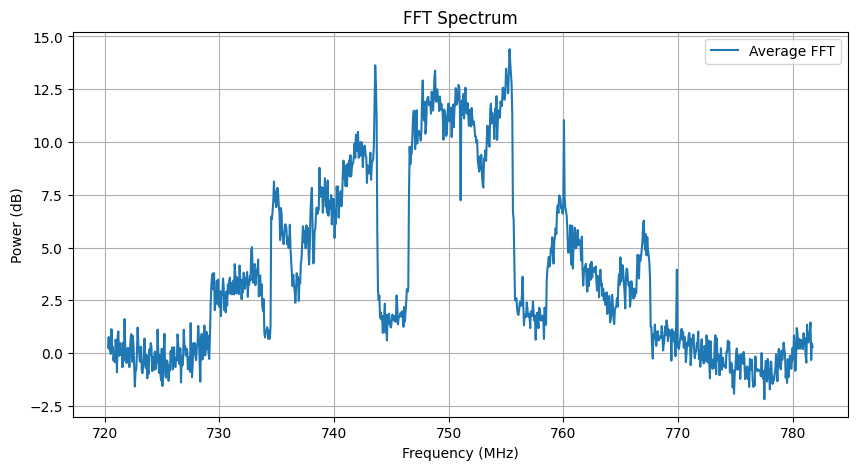

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

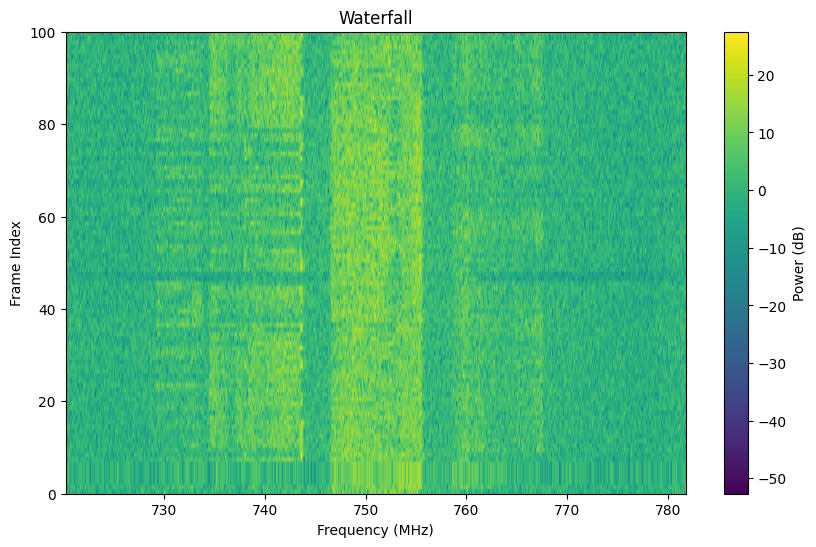

Done.


O

In [1]:
# SDR Data Reception and Visualization

import numpy as np
import matplotlib.pyplot as plt
from sdrfly.sdr.sdr_generic import SDRGeneric

# SDR Settings
CENTER_FREQ = 751e6  # Center frequency in Hz
SAMPLE_RATE = 61.44e6   # Sample rate in Hz
BANDWIDTH = 61.44e6     # Bandwidth in Hz
GAIN = 76            # Gain
SAMPLE_SIZE = 1024   # Number of samples per FFT frame
NUM_FRAMES = 100      # Number of frames for the waterfall plot

# Instantiate SDRGeneric
sdr = SDRGeneric(
    "sidekiq",
    center_freq=CENTER_FREQ,
    sample_rate=SAMPLE_RATE,
    bandwidth=BANDWIDTH,
    gain=GAIN,
    size=SAMPLE_SIZE
)
sdr.start()

# Receive and process data
def receive_and_process_data(num_frames):
    fft_data = []
    for _ in range(num_frames):
        iq_samples = sdr.get_latest_samples()  # Receive IQ samples
        fft_frame = np.abs(np.fft.fftshift(np.fft.fft(iq_samples)))  # Compute FFT
        fft_data.append(fft_frame)
    return np.array(fft_data)

# Plot the FFT and Waterfall
def plot_fft_and_waterfall(fft_data):
    # Plot FFT
    avg_fft = np.mean(fft_data, axis=0)
    freqs = np.linspace(-SAMPLE_RATE / 2, SAMPLE_RATE / 2, SAMPLE_SIZE) + CENTER_FREQ
    plt.figure(figsize=(10, 5))
    plt.plot(freqs / 1e6, 20 * np.log10(avg_fft), label="Average FFT")
    plt.title("FFT Spectrum")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (dB)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Waterfall
    plt.figure(figsize=(10, 6))
    plt.imshow(
        20 * np.log10(fft_data),
        aspect="auto",
        extent=[freqs[0] / 1e6, freqs[-1] / 1e6, 0, fft_data.shape[0]],
        cmap="viridis",
        origin="lower"
    )
    plt.title("Waterfall")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Frame Index")
    plt.colorbar(label="Power (dB)")
    plt.show()
    return avg_fft

# Main Functionality
if __name__ == "__main__":
    print("Receiving data from SDR...")
    fft_data = receive_and_process_data(NUM_FRAMES)
    print("Data reception complete. Plotting...")
    avg_fft = plot_fft_and_waterfall(fft_data)
    print("Done.")


Noise Floor: 2.60 dB, Threshold: 2.60 dB
Points above threshold: 512
Detected 11 peaks.


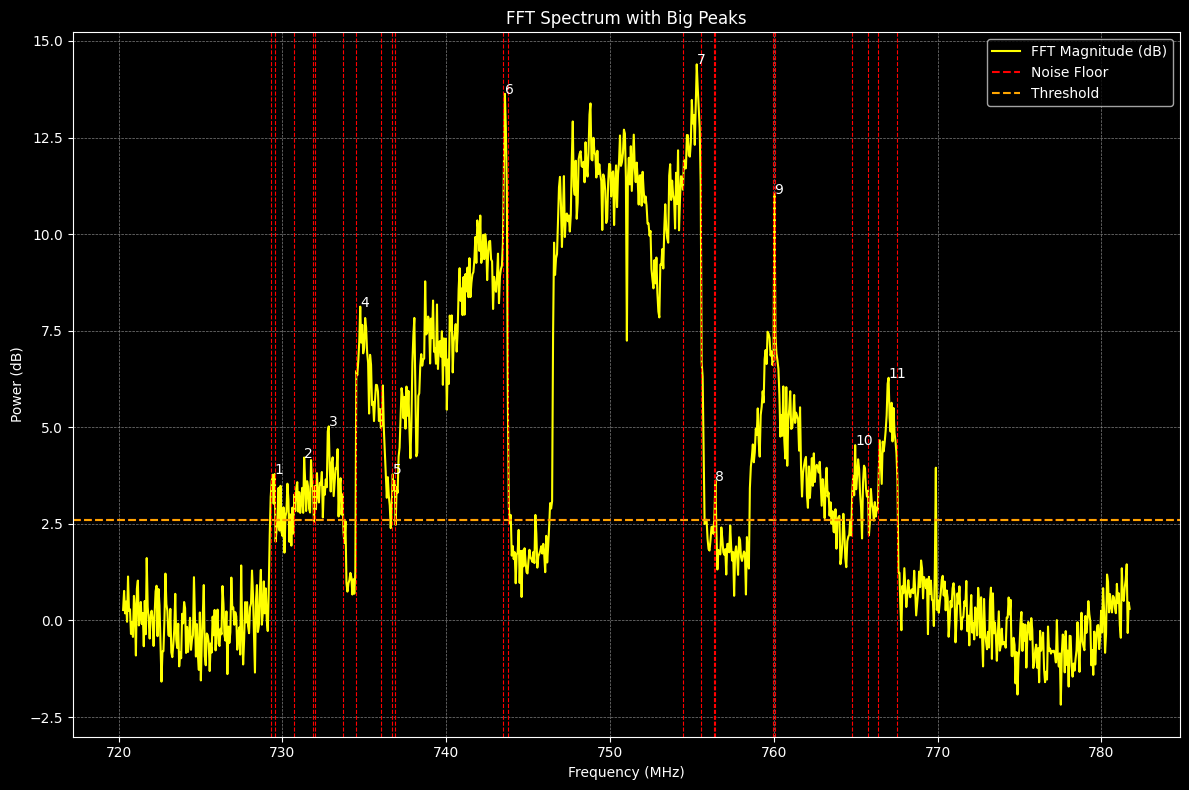

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

prominence_threshold = 1
bottom_limit = 3
threshold_offset = 0  # Threshold offset above noise floor in dB

# Example FFT data (replace with your real data)
freqs = np.linspace(CENTER_FREQ - SAMPLE_RATE // 2, CENTER_FREQ + SAMPLE_RATE // 2, len(avg_fft))  # Frequency axis in Hz
fft_magnitude_db = 20 * np.log10(avg_fft)  # Convert FFT magnitude to dB

# Calculate noise floor and threshold
noise_floor = np.median(fft_magnitude_db)  # Use median as noise floor
threshold = noise_floor + threshold_offset  # Threshold


def detect_big_signal_peaks_and_bandwidths_debug(fft_magnitude_db, freqs, noise_floor, prominence_threshold=1, threshold_offset=3, merge_distance=250e3,
                                                 limit=3):
    """
    Detect big peaks in the FFT data, calculate their bandwidths, and merge peaks within a specified distance.

    Parameters:
        fft_magnitude_db (array): The FFT magnitude in dB.
        freqs (array): Frequency axis in Hz.
        noise_floor (float): The noise floor level in dB.
        prominence_threshold (float): Minimum prominence (power above the threshold) for a peak to be considered significant.
        threshold_offset (float): Offset above noise floor to define the threshold in dB.
        merge_distance (float): Minimum distance between peaks to consider them separate (in Hz).

    Returns:
        signal_details (list): List of dictionaries containing peak center frequency,
                               bandwidth, and peak power for each significant signal.
    """
    threshold = noise_floor + threshold_offset
    print(f"Noise Floor: {noise_floor:.2f} dB, Threshold: {threshold:.2f} dB")

    # Identify points above the threshold
    above_threshold = np.where(fft_magnitude_db > threshold)[0]
    print(f"Points above threshold: {len(above_threshold)}")

    if len(above_threshold) == 0:
        print("No peaks detected above the threshold. Try lowering prominence_threshold or threshold_offset.")
        return []

    signal_details = []
    left_idx = None

    for i in range(1, len(above_threshold)):
        if left_idx is None:
            left_idx = above_threshold[i - 1]

        # If we find a gap larger than one index, it marks the end of a peak
        if above_threshold[i] - above_threshold[i - 1] > 1:
            right_idx = above_threshold[i - 1]
            peak_idx = left_idx + np.argmax(fft_magnitude_db[left_idx:right_idx + 1])
            peak_freq = freqs[peak_idx]  # Center frequency
            peak_power = fft_magnitude_db[peak_idx]  # Power of the peak

            # Calculate bandwidth (frequency range where power is above 3 dB below the peak)
            lower_bound = np.where(fft_magnitude_db[left_idx:peak_idx] < peak_power - limit)[0]
            upper_bound = np.where(fft_magnitude_db[peak_idx:right_idx + 1] < peak_power - limit)[0]

            lower_freq = freqs[left_idx + lower_bound[-1]] if lower_bound.size > 0 else freqs[left_idx]
            upper_freq = freqs[peak_idx + upper_bound[0]] if upper_bound.size > 0 else freqs[right_idx]

            bandwidth = upper_freq - lower_freq

            # Only keep peaks with sufficient prominence
            if peak_power - threshold >= prominence_threshold:
                # Merge peaks if the current peak is within the merge distance of the last one
                if signal_details and (peak_freq - signal_details[-1]["Upper Frequency"]) < merge_distance:
                    # Merge with the previous peak
                    signal_details[-1]["Upper Frequency"] = upper_freq
                    signal_details[-1]["Bandwidth"] = signal_details[-1]["Upper Frequency"] - signal_details[-1]["Lower Frequency"]
                    signal_details[-1]["Peak Power"] = max(signal_details[-1]["Peak Power"], peak_power)
                else:
                    # Add a new peak
                    signal_details.append({
                        "Center Frequency": peak_freq,
                        "Bandwidth": bandwidth,
                        "Peak Power": peak_power,
                        "Lower Frequency": lower_freq,
                        "Upper Frequency": upper_freq,
                    })

            left_idx = above_threshold[i]

    print(f"Detected {len(signal_details)} peaks.")
    return signal_details


# Adjust parameters if no peaks are detected
big_signal_details_debug = detect_big_signal_peaks_and_bandwidths_debug(
    fft_magnitude_db,
    freqs,
    noise_floor,
    prominence_threshold=prominence_threshold,  # Try lowering this value
    threshold_offset=threshold_offset,       # Try lowering this value
    limit=bottom_limit,
    merge_distance=1e6
)

# Set dark mode for the plot
plt.style.use("dark_background")

# Plot the FFT with detected peaks
plt.figure(figsize=(12, 8))
plt.plot(freqs / 1e6, fft_magnitude_db, label="FFT Magnitude (dB)", color="yellow")
plt.axhline(noise_floor, color='red', linestyle='--', label="Noise Floor")
plt.axhline(noise_floor + threshold_offset, color='orange', linestyle='--', label="Threshold")

# Annotate big peaks and bandwidths
for i, signal in enumerate(big_signal_details_debug, start=1):
    center_freq = signal["Center Frequency"]
    peak_power = signal["Peak Power"]
    lower_freq = signal["Lower Frequency"]
    upper_freq = signal["Upper Frequency"]

    plt.annotate(f"{i}", xy=(center_freq / 1e6, peak_power), color="white", fontsize=10)
    plt.axvline(x=lower_freq / 1e6, color="red", linestyle="--", linewidth=0.8)
    plt.axvline(x=upper_freq / 1e6, color="red", linestyle="--", linewidth=0.8)

plt.title("FFT Spectrum with Big Peaks", color="white")
plt.xlabel("Frequency (MHz)", color="white")
plt.ylabel("Power (dB)", color="white")
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# cleanup

sdr.stop()
sdr.close()

[INFO] Exiting RX Sidekiq Thread
python3[574779]: [card-0] <ERROR> At least one of the specified handles (A1) is not streaming
[ERROR] Failure: skiq_stop_rx_streaming (card 0)
python3[574779]: [card-0] <INFO> Unlocking card
